# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

from environment import TrafficModel, Car
from util.network import create_braess_network, create_double_braess_network, create_cars, build_network

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import trange

In [22]:
def create_multicommodity_braess_graph(p, *, capacity=1, degree=1):
    assert p % 2, 'p must be odd!'

    network = nx.DiGraph(
        [('s2', 'w0')] + [(f'w{i}', f'w{i + 1}') for i in range(0, p)] + [(f'w{p}', 't2')] + 
        [('s1', 'a'), ('a', 'w1'), ('w1', 'v1')] + [(f'v{i}', f'v{i + 1}') for i in range(1, p)] + [(f'v{p}', 't1')] + 
        [('a', f'w{i}') for i in range(2, p, 2)] + 
        [(f'v{i}', f'w{i}') for i in range(2, p, 2)] + 
        [('s2', f'v{i}') for i in range(1, p - 1, 2)] + 
        [(f'w{i}', f'v{i}') for i in range(1, p + 1, 2)] +
        [('s1', 'w0')]
    )

    nx.set_node_attributes(
        network, {
            's1': (0, 2 / (p+3)),
            'a': (1 / (p+4), 2 / (p+3)),
            **{f'v{i}': ((i+3) / (p+4), 2 / (p+3)) for i in range(1, p + 1)},
            't1': (1, 2 / (p+3)),
            's2': (2 / (p+4), 0),
            **{f'w{i}': (2 / (p+4), (i+1) / (p+3)) for i in range(0, p + 1)},
            't2': (2 / (p+4), 1)
        }, "position"
    )

    nx.set_edge_attributes(network, (0.01, 0, 1, 1), "latency_params")

    nx.set_edge_attributes(
        network, {
            ('w0', 'w1'): (0, 1, capacity, degree),
            **{(f'v{i}', f'v{i+1}') if i % 2 else (f'w{i}', f'w{i+1}'): (0, i, capacity, degree) for i in range(1, p)},
            ('s1', 'a'): (1, 0, 1, 1)
        }, "latency_params"
    )

    return build_network(network)

In [23]:
def draw_network(network):
    nx.draw(
        network,
        pos=nx.get_node_attributes(network, "position"),
        with_labels=True,
        font_size=8,
        edgelist=[(v, w) for v, w in network.edges if v != w]
    )

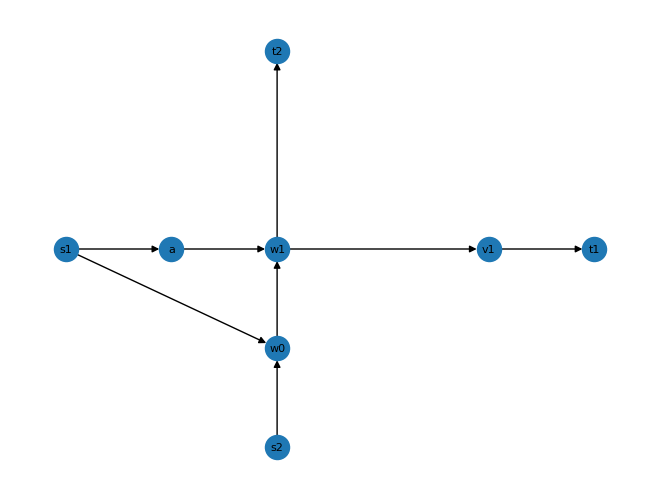

In [24]:
network = create_multicommodity_braess_graph(1)

draw_network(network)

In [28]:
p = 1
number_of_steps = 1000
car_counts = {('s1', 't1'): 30, ('s2', 't2'): 30}

network = create_multicommodity_braess_graph(p, capacity=10)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))

step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

print(f'Unrestricted mean travel time: {(-car_stats["travel_time"]).mean()}')

Unrestricted mean travel time: -3.9235058715475954


In [27]:
p = 1
number_of_steps = 1000
car_counts = {('s1', 't1'): 30, ('s2', 't2'): 30}

network = create_multicommodity_braess_graph(p, capacity=10)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
model.set_edge_restriction(('s1', 'w0'), False)

step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

print(f'Unrestricted mean travel time: {(-car_stats["travel_time"]).mean()}')

Unrestricted mean travel time: -3.423945998512671
